# Optimization with CVWPY 

In [100]:
%pylab inline
import time
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mu

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
reload(img_utils)

<module 'utils.img_utils' from 'utils/img_utils.pyc'>

## Load DWI

In [2]:
from utils.DataGetter import DataGetter
from utils.DownsampledImage import DownsampledImage

d = DataGetter()
datas_names = [
    DataGetter.STANDFORD_HARDI_DATA, #(81, 106, 76, 160)
    #DataGetter.TAIWAN_NTU_DSI_DATA,  #(96, 96, 60, 203)
    #DataGetter.SHERBROOKE_3SHELL_DATA #(128, 128, 60, 193)
]

scale=2
datas = d.get_data(datas_names)
name = datas_names[0]
gtab = datas[name]['gtab']

lr_hr_img = DownsampledImage(name, datas[name]['img'], gtab, scale)

img_hr = lr_hr_img.get_hr_img().astype(float)
img_lr = lr_hr_img.get_lr_img().astype(float)
    

/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 


## Select Area of Interest

In [ ]:
img_shape = img_lr.shape
x0,xf, y0,yf, z0,zf = volume_range_lr = (22, 28, 15, 21, 23, 29)
b0, bf = bval_range = (10,16)
gdirections = lr_hr_img.gtab.bvecs[b0:bf]

# Type and intensiti of noise to apply
SNR, SNR_TYPE = 25, 'gaussian'

#img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf] = (img_hr[2*x0:2*xf, y0, 2*z0:2*zf, b0:bf].max())*np.ones((12,12,12,6))

i_lr = img_lr[x0:xf, y0:yf, z0:zf, b0:bf]
i_hr = img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf]


In [113]:
## Save i_hr ##
np.save('./resultados/i_hr', i_hr)
np.save('./resultados/i_lr', i_lr)


('b=2000, G directions =',
 array([[  2.18280000e-02,   8.02420000e-01,  -5.96360000e-01],
        [ -1.54250000e-02,   2.20980000e-01,   9.75160000e-01],
        [ -7.09180000e-01,  -6.31060000e-04,  -7.05030000e-01],
        [ -2.46500000e-01,   1.04300000e-01,  -9.63510000e-01],
        [ -4.83470000e-01,   4.39100000e-01,  -7.57260000e-01],
        [  1.51030000e-01,   9.65230000e-01,   2.13360000e-01]]))

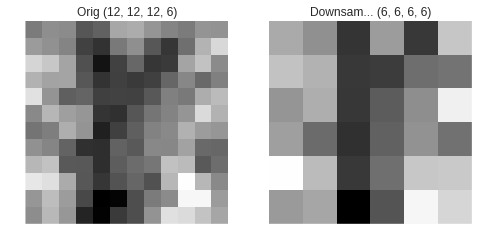

In [3]:
img_utils._isc(i_hr,i_lr,titles=['Orig '+ str(i_hr.shape), 'Downsam... '+str(i_lr.shape)] )
'b=2000, G directions =', gdirections


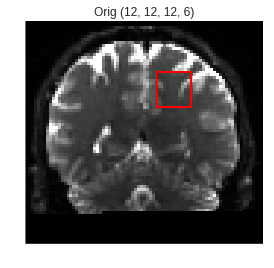

(81, 12, 76) y= 6
HR max,min 989.0 56.3402134135 79.521167049


In [112]:
reload(img_utils)
reload(plt)
rect_hr = 2*z0, 2*x0, 2*xf-2*x0, 2*zf-2*z0

res=img_utils._iswr(img_hr[:,2*y0:2*yf,:,0],  rect_hr, b=1,title='Orig '+ str(i_hr.shape), vmax=2500)
#res[1].savefig('/user/lgomez/home/Documents/tesis/optimizacion/img/hardi.pdf')
print 'HR max,min', img_hr[:,:,:,10:16].max(), img_hr[:,:,:,10:16].mean(), np.std(img_hr[:,:,:,10:16])
#print rect_hr

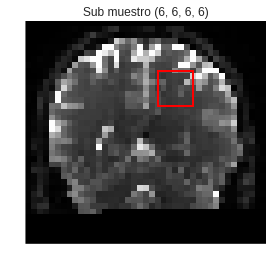

(41, 6, 38) y= 3
LR max,min 0.0 12067.0
(23, 22, 6, 6)


In [110]:
reload(img_utils)

rect_lr = z0, x0, xf-x0, zf-z0

res =img_utils._iswr(img_lr[:,y0:yf,:,0], rect_lr,b=1, title='Sub muestro '+str(i_lr.shape), vmax=2500)
#res[1].savefig('/user/lgomez/home/Documents/tesis/optimizacion/img/downsampling.pdf')
print 'LR max,min', img_lr.min(), img_lr.max()
print rect_lr

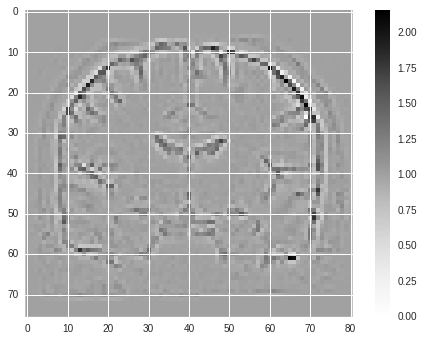

In [24]:
import scipy.ndimage.filters as fil

imgd = np.rot90(mu.normalize(fil.laplace(img_hr[:,img_hr.shape[1]/2,:,0])))

imshow(1-imgd, interpolation='none')
colorbar()


# Predicting the G downsampling Matrix

## Training set generator

In [121]:
from dipy.sims import phantom

def buildT(i_hr, snr, snr_type, n_samples):
    noised_hr = phantom.add_noise(i_hr, snr=snr, noise_type=SNR_TYPE)
    noised_lr = img_utils.downsampling2(noised_img, scale)
    X = img_utils.column_this(noised_lr)
    Y = img_utils.column_this(noised_hr)
    for i in range(1, n_samples):
        noised_hr = phantom.add_noise(i_hr, snr=snr, noise_type=SNR_TYPE)
        noised_lr = img_utils.downsampling2(noised_img, scale)
        X = img_utils.append_column(X, noised_lr)
        Y = img_utils.append_column(Y, noised_hr)
    return X, Y

## Build a traininset $T^{snr}$

(12, 12, 12, 6) y= 6


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

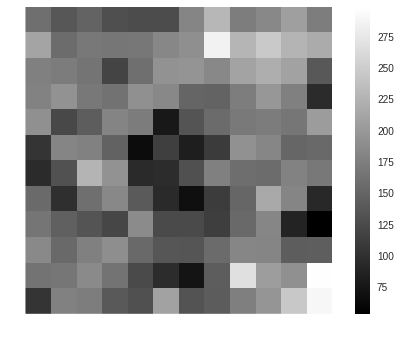

In [11]:
n_samples = 10
X, Y = buildT(i_hr, SNR, SNR_TYPE, n_samples)

# Show one of samples
img_utils._is(Y[:, 1].reshape(i_hr.shape), b=1)

In [6]:
reload(rr)
reload(sc)
reload(db)
reload(ixs)
import utils.dmri_patch_operations.DmriPatch as patchs
reload(patchs)

<module 'utils.dmri_patch_operations.DmriPatch' from 'utils/dmri_patch_operations/DmriPatch.pyc'>

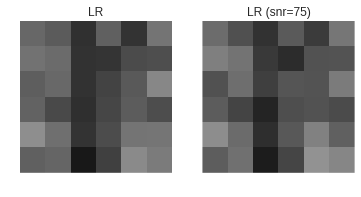

In [117]:
## Compare one sample and original HR version
VMIN, VMAX = 0,408
#X, Y = buildT(i_hr, t_snr, 75, n_samples)
img_utils._isc(i_lr, X[:, 2].reshape(i_lr.shape), b=0, titles=['LR', 'LR (snr='+str(75)+')'], vmin=VMIN, vmax=VMAX)
#mse_feta = mu.mse(i_hr[:,:,:,1], Y[:, 2].reshape(i_hr.shape)[:,:,:,1])
#print 'mse(HR_orig, HR_2_sample)=' , mse_feta, 'sqrt(mse)=', sqrt(mse_feta)
plt.savefig('/user/lgomez/home/Documents/tesis/optimizacion/img/lr_Tsnr75.pdf')

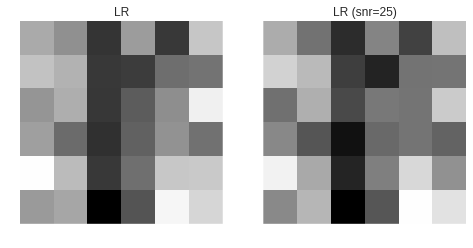

In [15]:
## Compare one sample and original LR version
plt =img_utils._isc(i_lr, X[:, 9].reshape(i_lr.shape), b=0, titles=['LR', 'LR (snr='+str(SNR)+')'])

### Training

In [16]:
from scipy.sparse import csr_matrix, csc_matrix
import experimento1_funciones as e1f
#reload(e1f)

# Calculamos la matriz de downsampling
regr, Y_train , X_train, Y_test, X_test = e1f.train(Y,X)

regr.coef_ = csr_matrix(regr.coef_)
type(regr.coef_), regr.coef_.shape, SNR

Training set_training.shape= (10368, 9)  ->target.shape= (1296, 9)


(scipy.sparse.csr.csr_matrix, (1296, 10368), 25)

## Problem definition

$ \min_{Y_{hr}} \{ ||GY_{lr} - Y_{hr}||^2 \}$ st $Y_{hr} \geq 0$

In [26]:
Nx, Ny, Nz, bval = i_hr.shape
vhrb = Nx*Ny*Nz*bval
vlr = Nx*Ny*Nz/8


Yhr = cvx.Variable(vhrb, 1)
Ylr = cvx.Parameter(vlr*bval, 1)
#Ylr.value = i_lr.reshape((vlr*bval, 1))
G = cvx.Parameter(*regr.coef_.shape, value=regr.coef_)

# Form objective.
obj = cvx.Minimize(cvx.sum_squares(G*Yhr - Ylr))

# Create two constraints.
#constraints = [Yhr >= 0]

# Form and solve problem.
prob = cvx.Problem(obj)
prob, prob.is_dcp()

(Problem(Minimize(Expression(CONVEX, POSITIVE, (1, 1))), []), True)

### Motor SCS (mas veloz menos preciso)

In [123]:
def solveMin(prob, i_lr, lr_snr, iterations, t_snr, folder=None):
    snrs=np.ones(iterations)*lr_snr
    
    Yhr_norms = []
    times = []
    dif_norms = []
    Ylr_norms = []
    optimal_vals = []
    for lr_snr in snrs:

        noised_lr = i_lr
        if lr_snr <= 100:
            noised_lr = phantom.add_noise(i_lr, snr=lr_snr, noise_type=SNR_TYPE)
        Ylr.value = noised_lr.reshape((vlr*bval, 1))

        start_time = time.time()
        res = prob.solve(solver='SCS', max_iters=2100, eps=1.00e-01 )  # Returns the optimal value.
        seg = time.time() - start_time
        
        minutes = int(seg / 60)
        print("--- time of optimization : %d' %d'' --- num. Tsnr: %s Ylr_snr: %s" % (minutes , seg%60, str(t_snr), str(lr_snr)))
        print "--- status:", prob.status, "optimal value", prob.value
        print 

    
        # Keep parameters
        dif_norm = np.linalg.norm(i_hr-A)
        Yhr_norm = np.linalg.norm(A)
        Ylr_norm = np.linalg.norm(noised_lr)
        Yhr_norms.append(Yhr_norm)
        Ylr_norms.append(Ylr_norm)
        dif_norms.append(dif_norm)
        times.append(seg)
        optimal_vals.append(prob.value)
    
    # Save the last A calculated
    A = np.asarray(Yhr.value).reshape(i_hr.shape)    
    if folder is not None:
        sufix = '_Tsnr'+str(t_snr)+'_lrsnr'+str(lr_snr)
        np.save(folder + '/A' + sufix, A)
        print 'saved A in: ', folder + '/A' + sufix

    
    return Yhr_norms, Ylr_norms, dif_norms, times, optimal_vals


In [120]:
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f

SNRs = [50, 75, 100, 200, float('inf')]
#SNRs = [float('inf')]

for t_snr in SNRs :
    n_samples = 10
    X, Y = buildT(i_hr, t_snr, SNR_TYPE, n_samples)
    
    # Build downsampling matrix
    regr, Y_train , X_train, Y_test, X_test = e1f.train(Y,X)
    regr.coef_ = csr_matrix(regr.coef_)
    G.value = regr.coef_
    
    # Minimization solveMin(prob, i_lr, lr_snr, iterations, t_snr, folder=
    Yhr_norms, Ylr_norms, dif_norms, times, optimal_vals = solveMin(prob, i_lr, 50, 30,  t_snr, './resultados/reconstruc')
    
    # Log time spended
    total_sec = np.array(times).sum()
    print ' === Tsnr('+str(t_snr)+'):',  str(total_sec//60)+"'", str(total_sec%60)+ '"'
    
    # Persist results
    base_folder = './resultados/'
    np.save(base_folder+ 'Yhr_norms/Yhr_norms_Tsnr' + str(t_snr), Yhr_norms)
    np.save(base_folder+ 'Ylr_norms/Ylr_norms_Tsnr' + str(t_snr), Ylr_norms)
    np.save(base_folder+ 'dif_norms/dif_norms_Tsnr' + str(t_snr), dif_norms)
    np.save(base_folder+ 'times/times_Tsnr' + str(t_snr), times)
    np.save(base_folder+ 'optimal_vals/optimal_vals_Tsnr' + str(t_snr), optimal_vals)
    


Training set_training.shape= (10368, 9)  ->target.shape= (1296, 9)
WARN: m less than n, problem likely degenerate
--- time of optimization : 5' 58'' --- num. Tsnr: inf Ylr_snr: 50.0
--- status: optimal_inaccurate optimal value 3059.46803496

saved A in:  ./resultados/reconstruc/A_Tsnrinf_lrsnr50.0
WARN: m less than n, problem likely degenerate
--- time of optimization : 4' 59'' --- num. Tsnr: inf Ylr_snr: 50.0
--- status: optimal_inaccurate optimal value 2996.76962965

saved A in:  ./resultados/reconstruc/A_Tsnrinf_lrsnr50.0
WARN: m less than n, problem likely degenerate
--- time of optimization : 5' 0'' --- num. Tsnr: inf Ylr_snr: 50.0
--- status: optimal_inaccurate optimal value 3101.76302731

saved A in:  ./resultados/reconstruc/A_Tsnrinf_lrsnr50.0
WARN: m less than n, problem likely degenerate
--- time of optimization : 5' 0'' --- num. Tsnr: inf Ylr_snr: 50.0
--- status: optimal_inaccurate optimal value 3007.87060817

saved A in:  ./resultados/reconstruc/A_Tsnrinf_lrsnr50.0
WARN: m